Preparation and exploratory data analysis of a craiglist dataset.

In [1]:
# Load necessary packages
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DateType, FloatType
from pyspark.sql.functions import col, to_date, year
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

# Spark session
spark = SparkSession.builder.appName('Craiglist').getOrCreate()

# Read dataset
vehiclesData = spark.read.option("inferSchema", "true").option("header", "true").csv("vehicles.csv")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/25 11:26:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Data Pre-Processing

 - remove unnecessary values
 - handle null values
 - align data types
 - feature engineer


In [2]:
# Drop unnecessary columns
to_drop = ['_c0','id','url','region','region_url','cylinders','fuel','odometer','title_status','VIN','drive','size','image_url','description']

vehiclesData = vehiclesData.drop(*to_drop).dropna()

In [3]:
# Change data types and restructure posting_date column
vehiclesData = vehiclesData\
                    .withColumn("price", vehiclesData["price"].cast(FloatType()))\
                    .withColumn("year", vehiclesData["year"].cast(IntegerType()))\
                    .withColumn("lat", vehiclesData["lat"].cast(IntegerType()))\
                    .withColumn("long", vehiclesData["long"].cast(IntegerType()))\
                    .withColumn("posting_date", vehiclesData["posting_date"].cast(DateType()))\
                    .withColumn("posting_date", to_date(col("posting_date")))\
                    .withColumn('posting_year', year(col("posting_date")))
               

In [4]:
# Drop rows with null values and irrelevant posting year values
years_to_drop = [1500, 1996, 3500]
vehiclesData = vehiclesData.filter(~vehiclesData["posting_year"].isin(years_to_drop))

Exploratory Data Analysis

In [5]:
# Set Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(12,5), titlesize=18, titleweight='bold',)
plt.rc('axes', labelweight='bold', labelsize='large',titleweight='bold',titlesize=16, titlepad=10,)
plot_params = dict(color='0.75',style='.-',markeredgecolor='0.25', markerfacecolor='0.25',legend=False,)
%config InlineBackend.figure_format ='retina'


/tmp/ipykernel_21010/2184689479.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [6]:
# Check the updated schema
vehiclesData.printSchema()

root
 |-- price: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: integer (nullable = true)
 |-- long: integer (nullable = true)
 |-- posting_date: date (nullable = true)
 |-- posting_year: integer (nullable = true)



In [7]:
# Convert to pandas dataframe
vehicles_pandas = vehiclesData.toPandas()

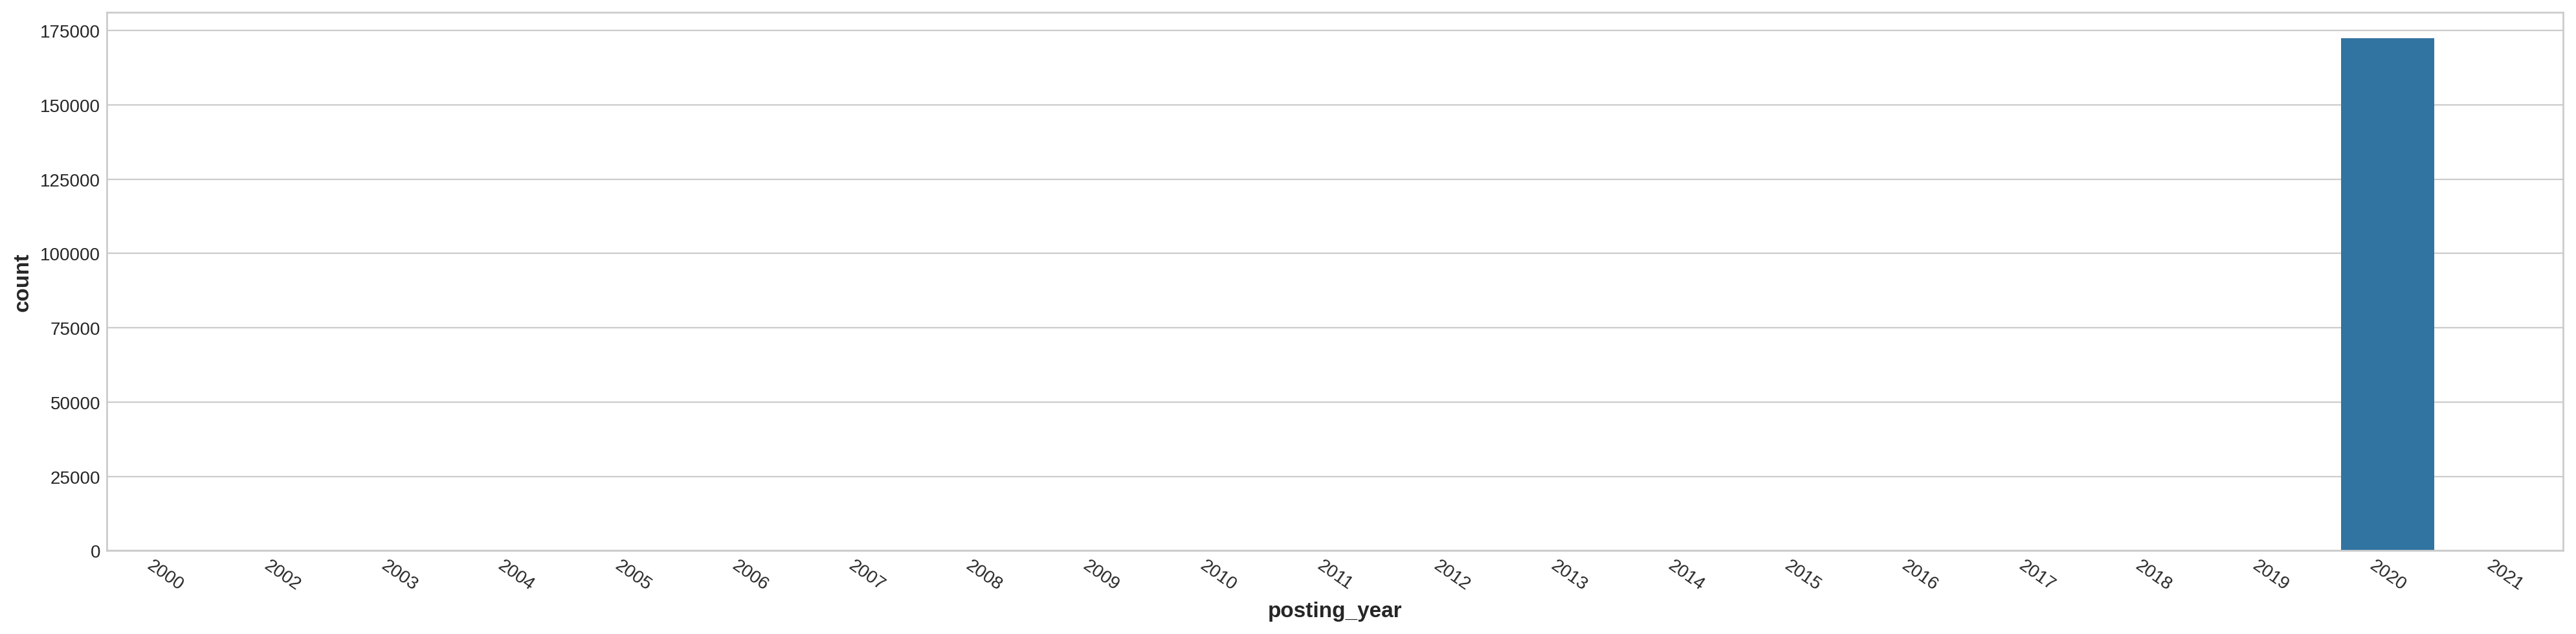

In [8]:
# Compare yearly sales
vehicles_pandas["posting_year"] = vehicles_pandas["posting_year"].astype(int)
plt.figure(figsize=(20,5))
plt.xticks(rotation= -35)
sns.countplot(data= vehicles_pandas,x="posting_year")
plt.show()

Vehicles posted at craiglist in 2020 depicts outlier behaviour. Later on, I shall decide on how to handle the year in order to deal with other timeframes that follow some defined trends. Our dataset does not track vehicle data for the year 2001.

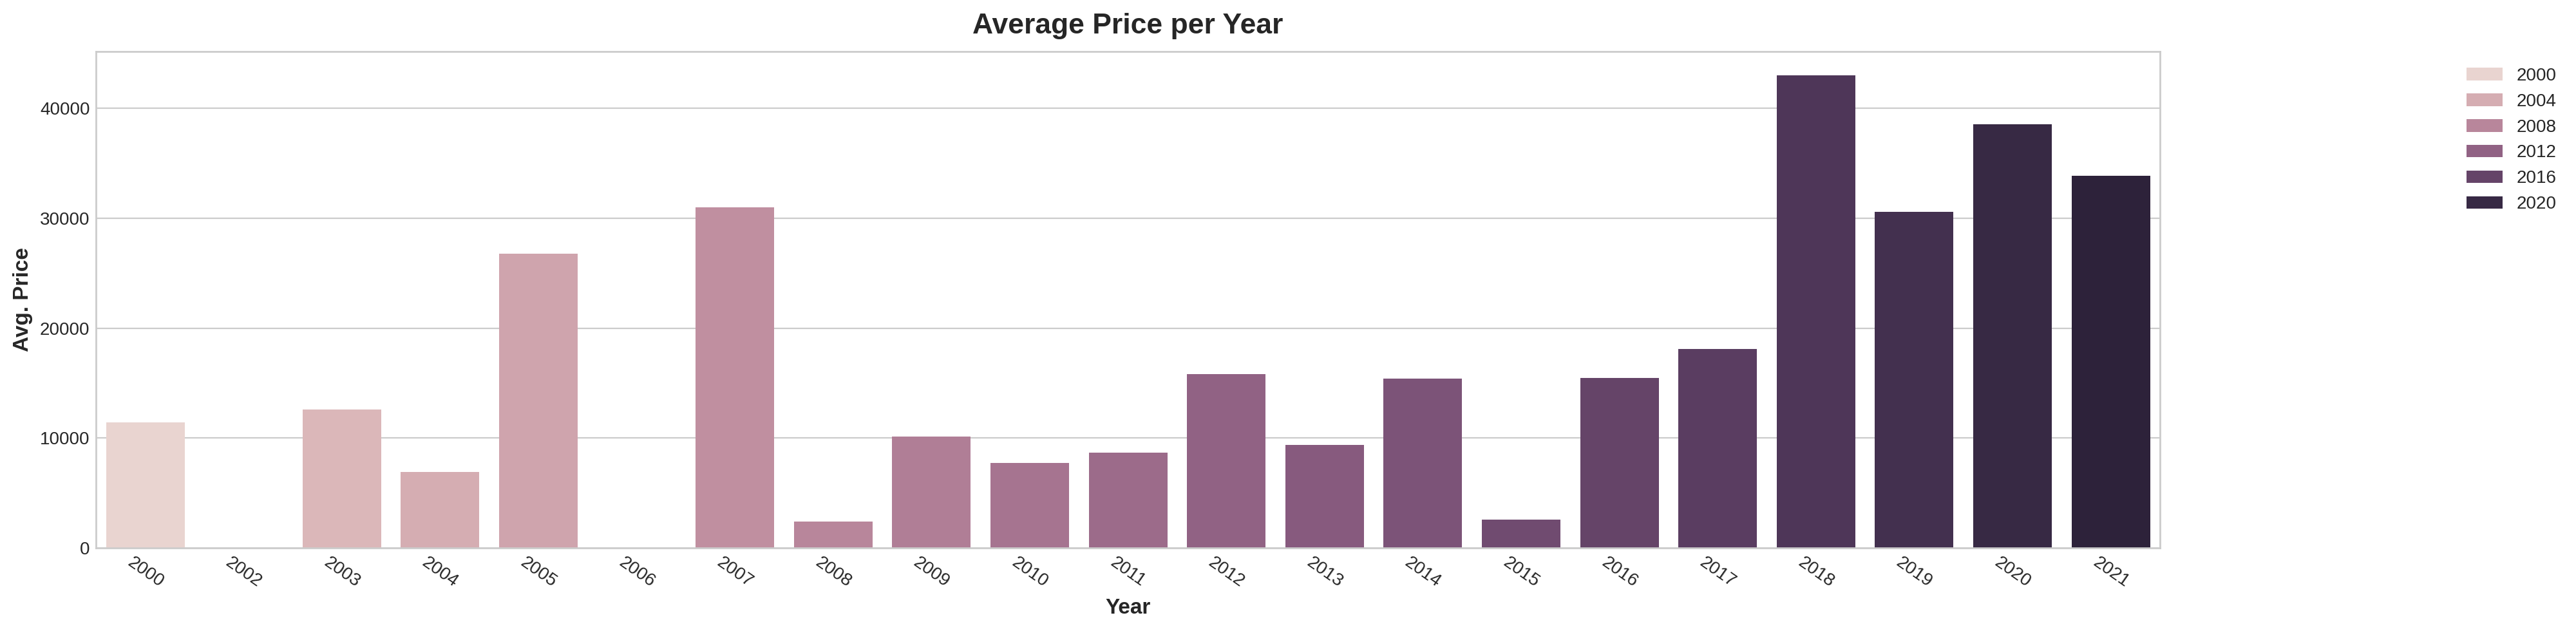

In [9]:
# Average price comparison per year
mean_prices = vehicles_pandas.groupby("posting_year")["price"].mean().reset_index()

plt.figure(figsize=(20,5))
plt.xticks(rotation= -35)
plt.xlabel('Year')
plt.ylabel('Avg. Price')
sns.barplot(data= mean_prices,x="posting_year", y= "price",hue="posting_year")
plt.title('Average Price per Year')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

There was flactuation on the average prices for years before 2008 from where we registered significant increments on the mean prices. The year 2018 closed the highest mean prices.

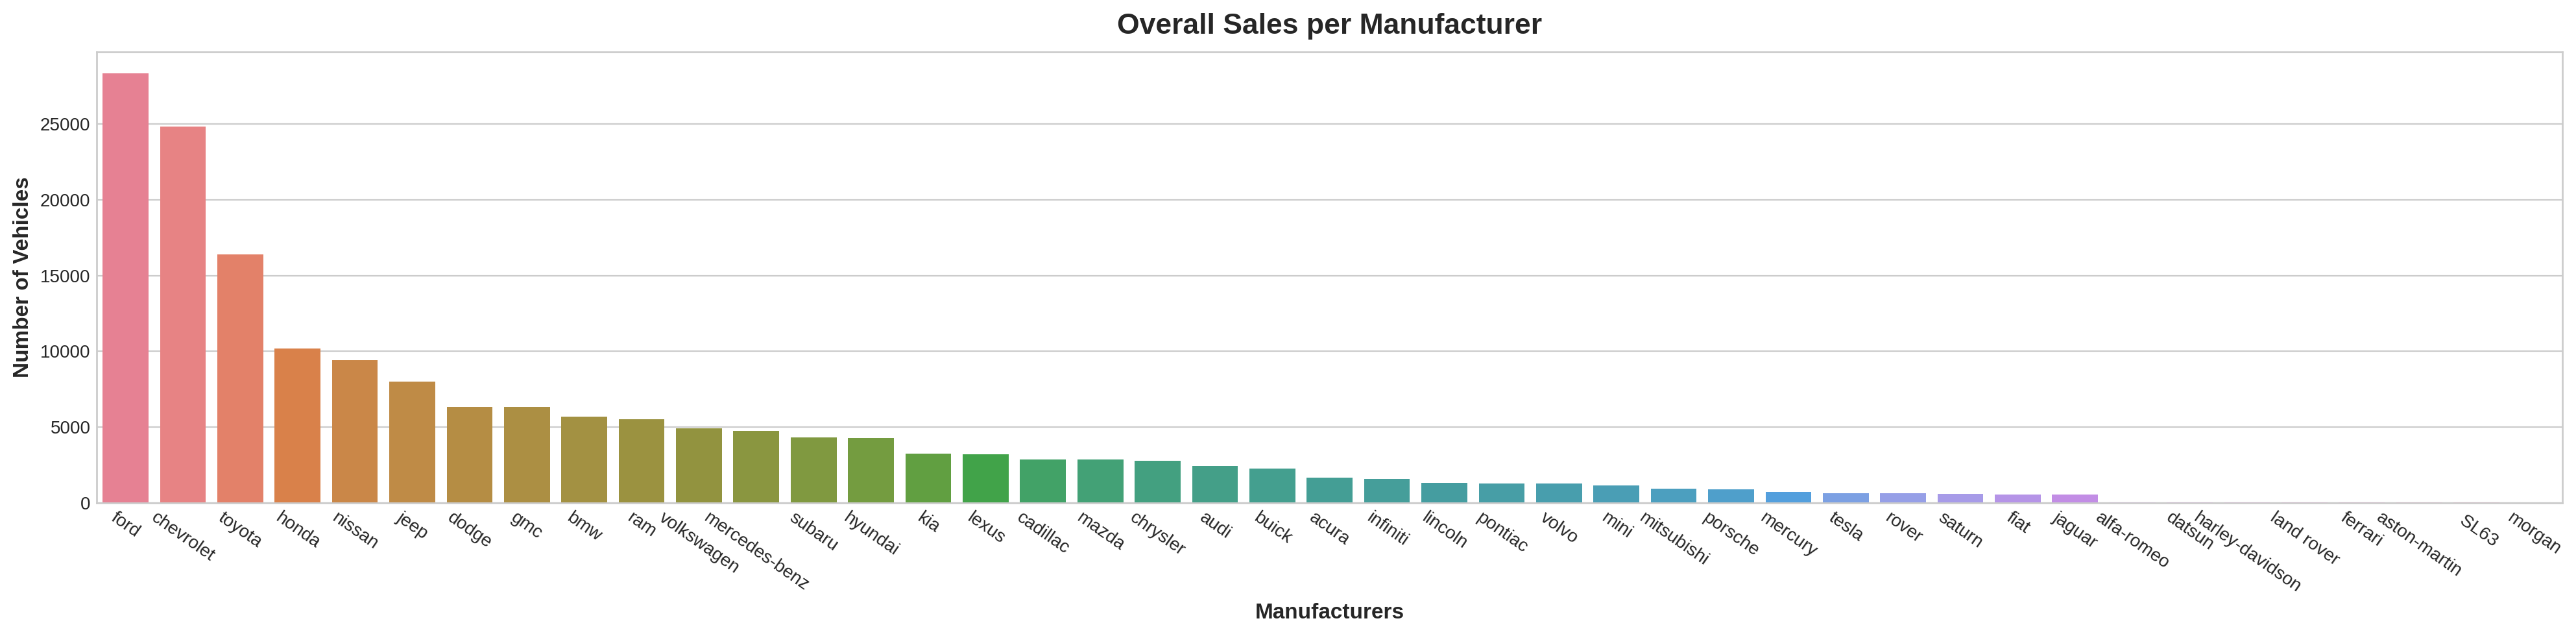

In [10]:
# Overall sales by Manufacturer

# group by manufacturer and posting_year
manufacturer_counts = vehicles_pandas.groupby("manufacturer")["posting_year"].count().reset_index(name="count")
# sort by count in descending order
manufacturer_counts = manufacturer_counts.sort_values(by="count", ascending=False)
# plot a bar plot
plt.figure(figsize=(20,5))
plt.xticks(rotation= -35)
sns.barplot(data= manufacturer_counts,x="manufacturer",y="count",hue="manufacturer")
plt.xlabel("Manufacturers")
plt.ylabel("Number of Vehicles")
plt.title("Overall Sales per Manufacturer")
plt.show()

Ford is the leading car manufacturer listed on craiglist, followed closely by Chevrolet. I am going to check how the sale of ford models over the years tracked compare.

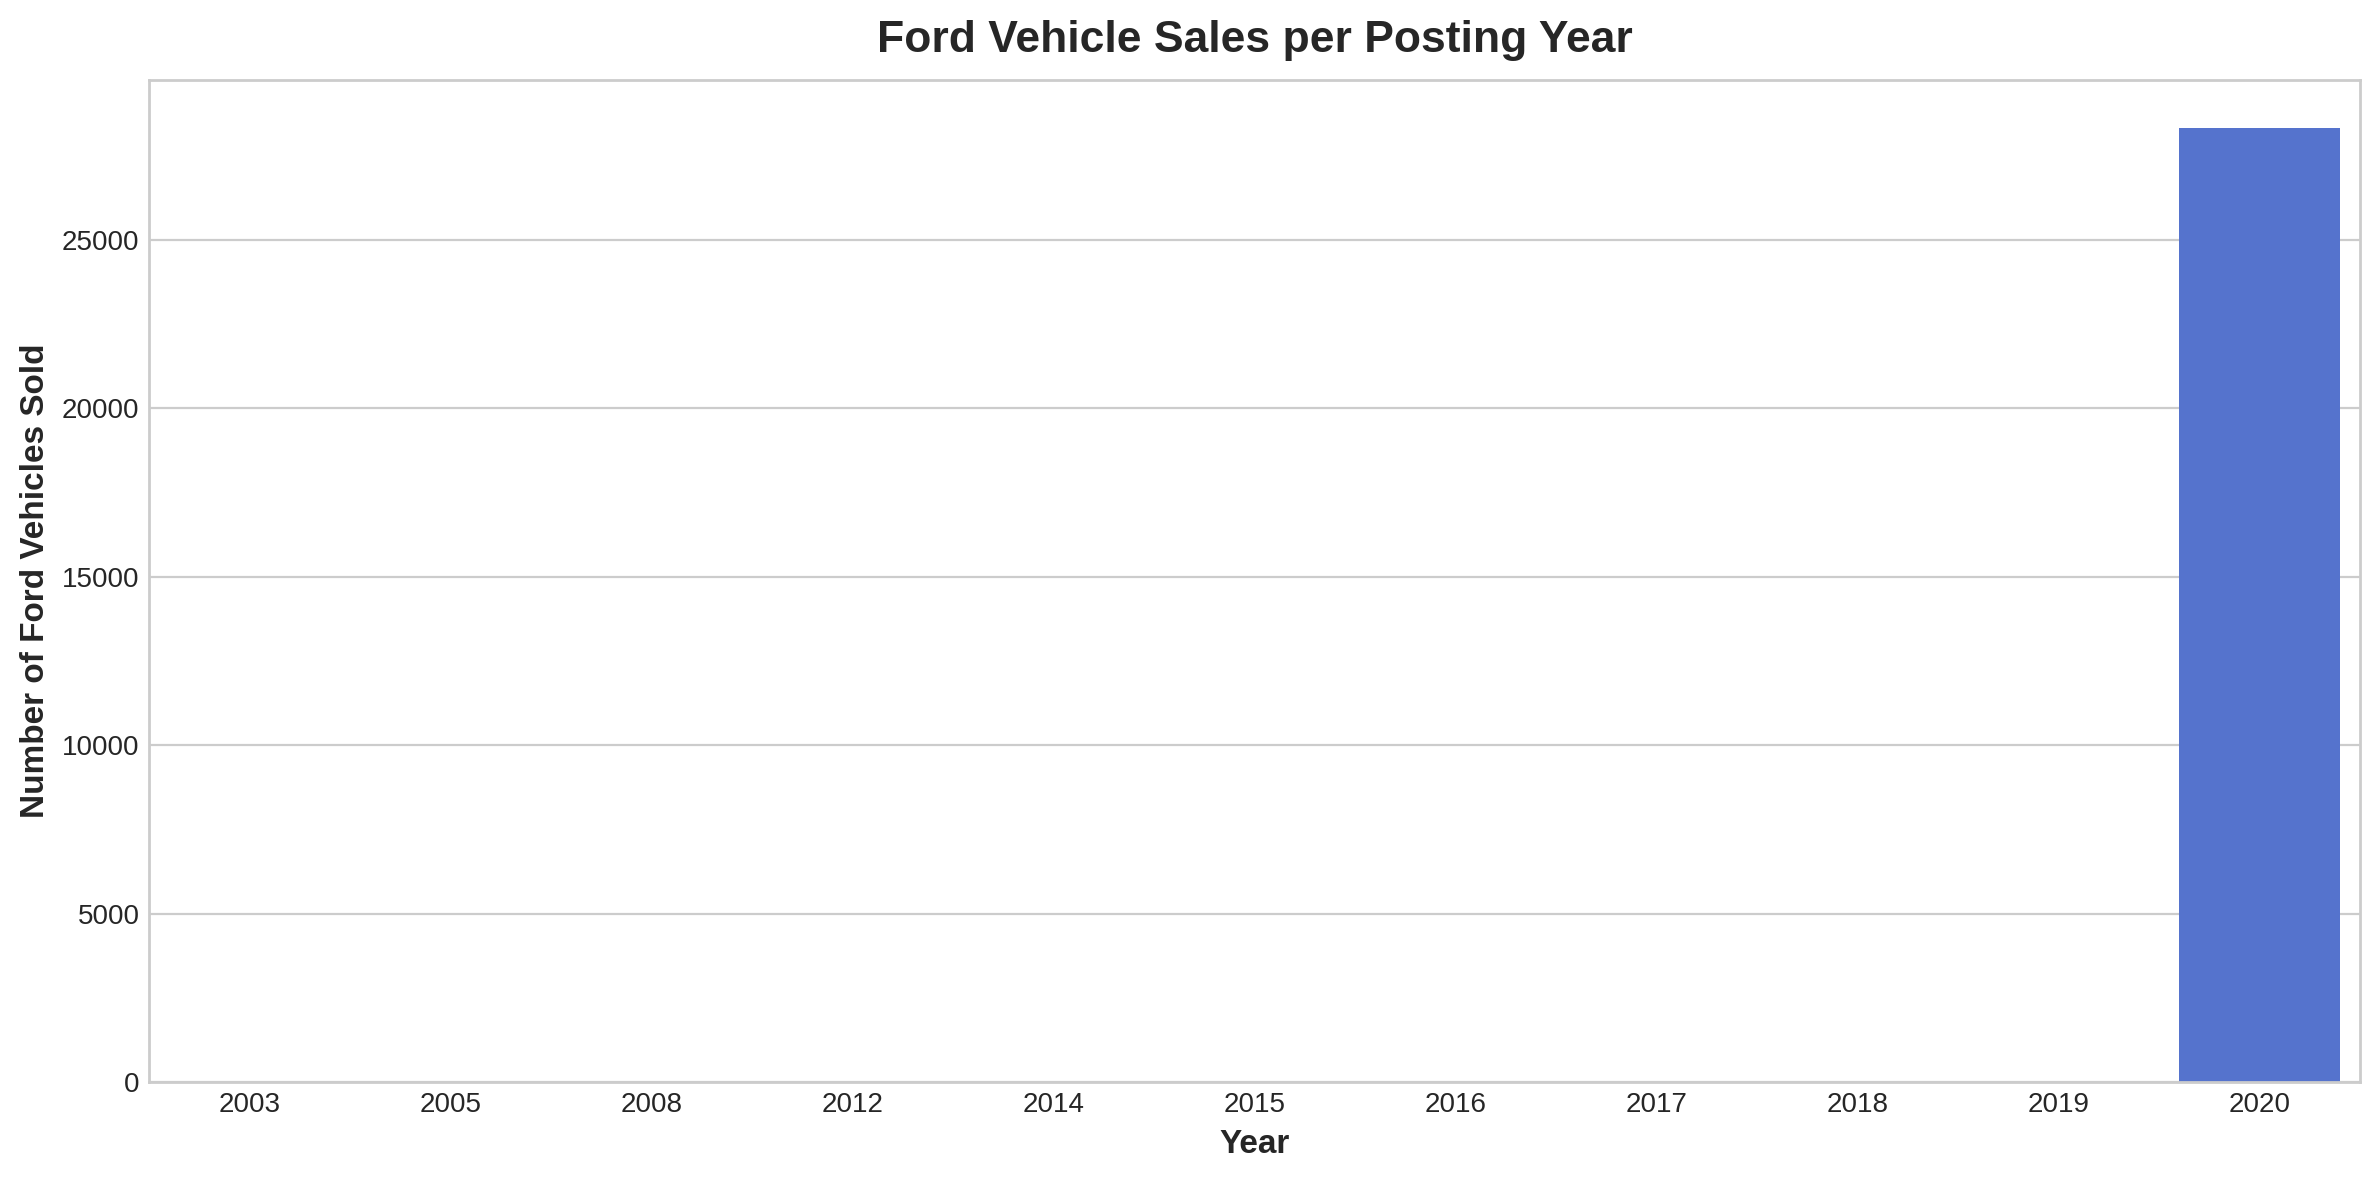

In [11]:
# Sales of Ford vehicles

# filter data for ford manufacturer
ford_sales = vehicles_pandas[vehicles_pandas["manufacturer"] == "ford"]
# group by posting_year and count the vehicles
ford_annual_sales = ford_sales.groupby("posting_year").size().reset_index(name="sales")

# plot the sales
plt.figure(figsize=(12, 6))
sns.barplot(data=ford_annual_sales, x='posting_year', y='sales', color='royalblue')
plt.xlabel('Year')
plt.ylabel('Number of Ford Vehicles Sold')
plt.title('Ford Vehicle Sales per Posting Year')
plt.show()


Again, the year 2020 like the overall vehicle sales had ford register substantial sales in comparison to other years. Ford vehicles were first sold in 2003 unlike others which have been listed since 2000.

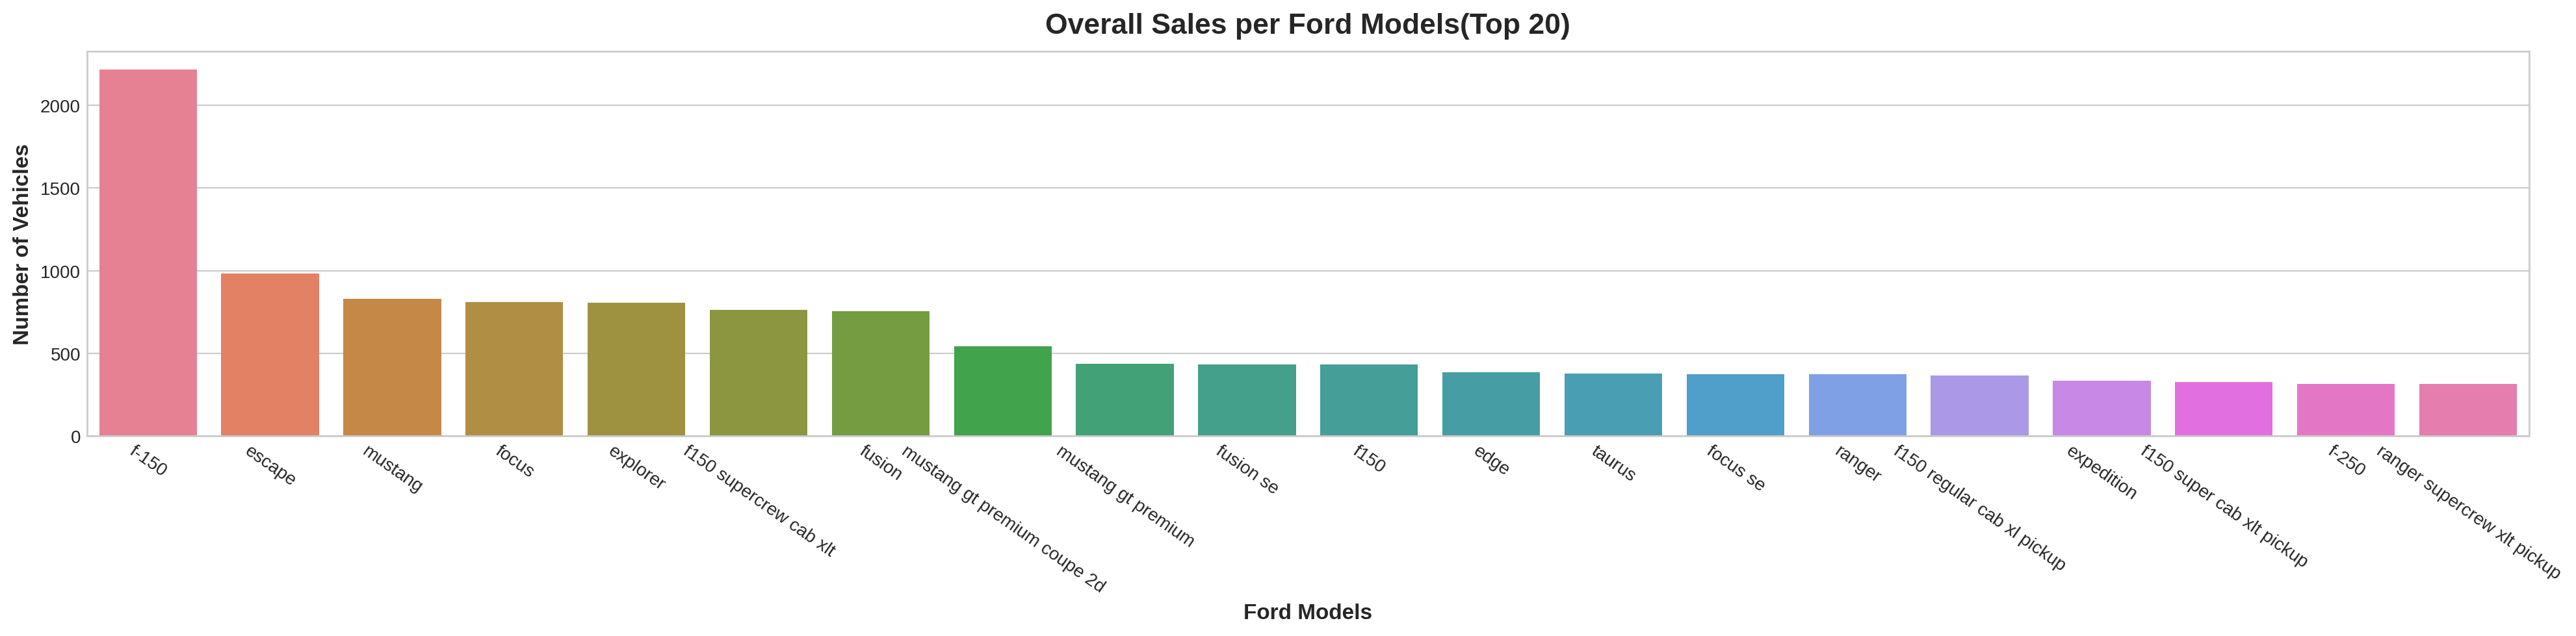

In [12]:
# Sales of Ford models

# group by model and count number of each model
ford_models = ford_sales["model"].value_counts().reset_index(name="count")
# sort by count
ford_models = ford_models.sort_values(by="count", ascending=False)
# select top 20
top_20_ford_models = ford_models.head(20)
# plot sales by models
plt.figure(figsize=(20,5))
plt.xticks(rotation=-35)
sns.barplot(data=top_20_ford_models, x="model", y="count",hue="model")
plt.xlabel("Ford Models")
plt.ylabel("Number of Vehicles")
plt.title("Overall Sales per Ford Models(Top 20)")
plt.show()


f-150 model over the years has closed larger sales volume in comparison to other ford models. The model is so popular as evident by more variants of registering noticable sales.

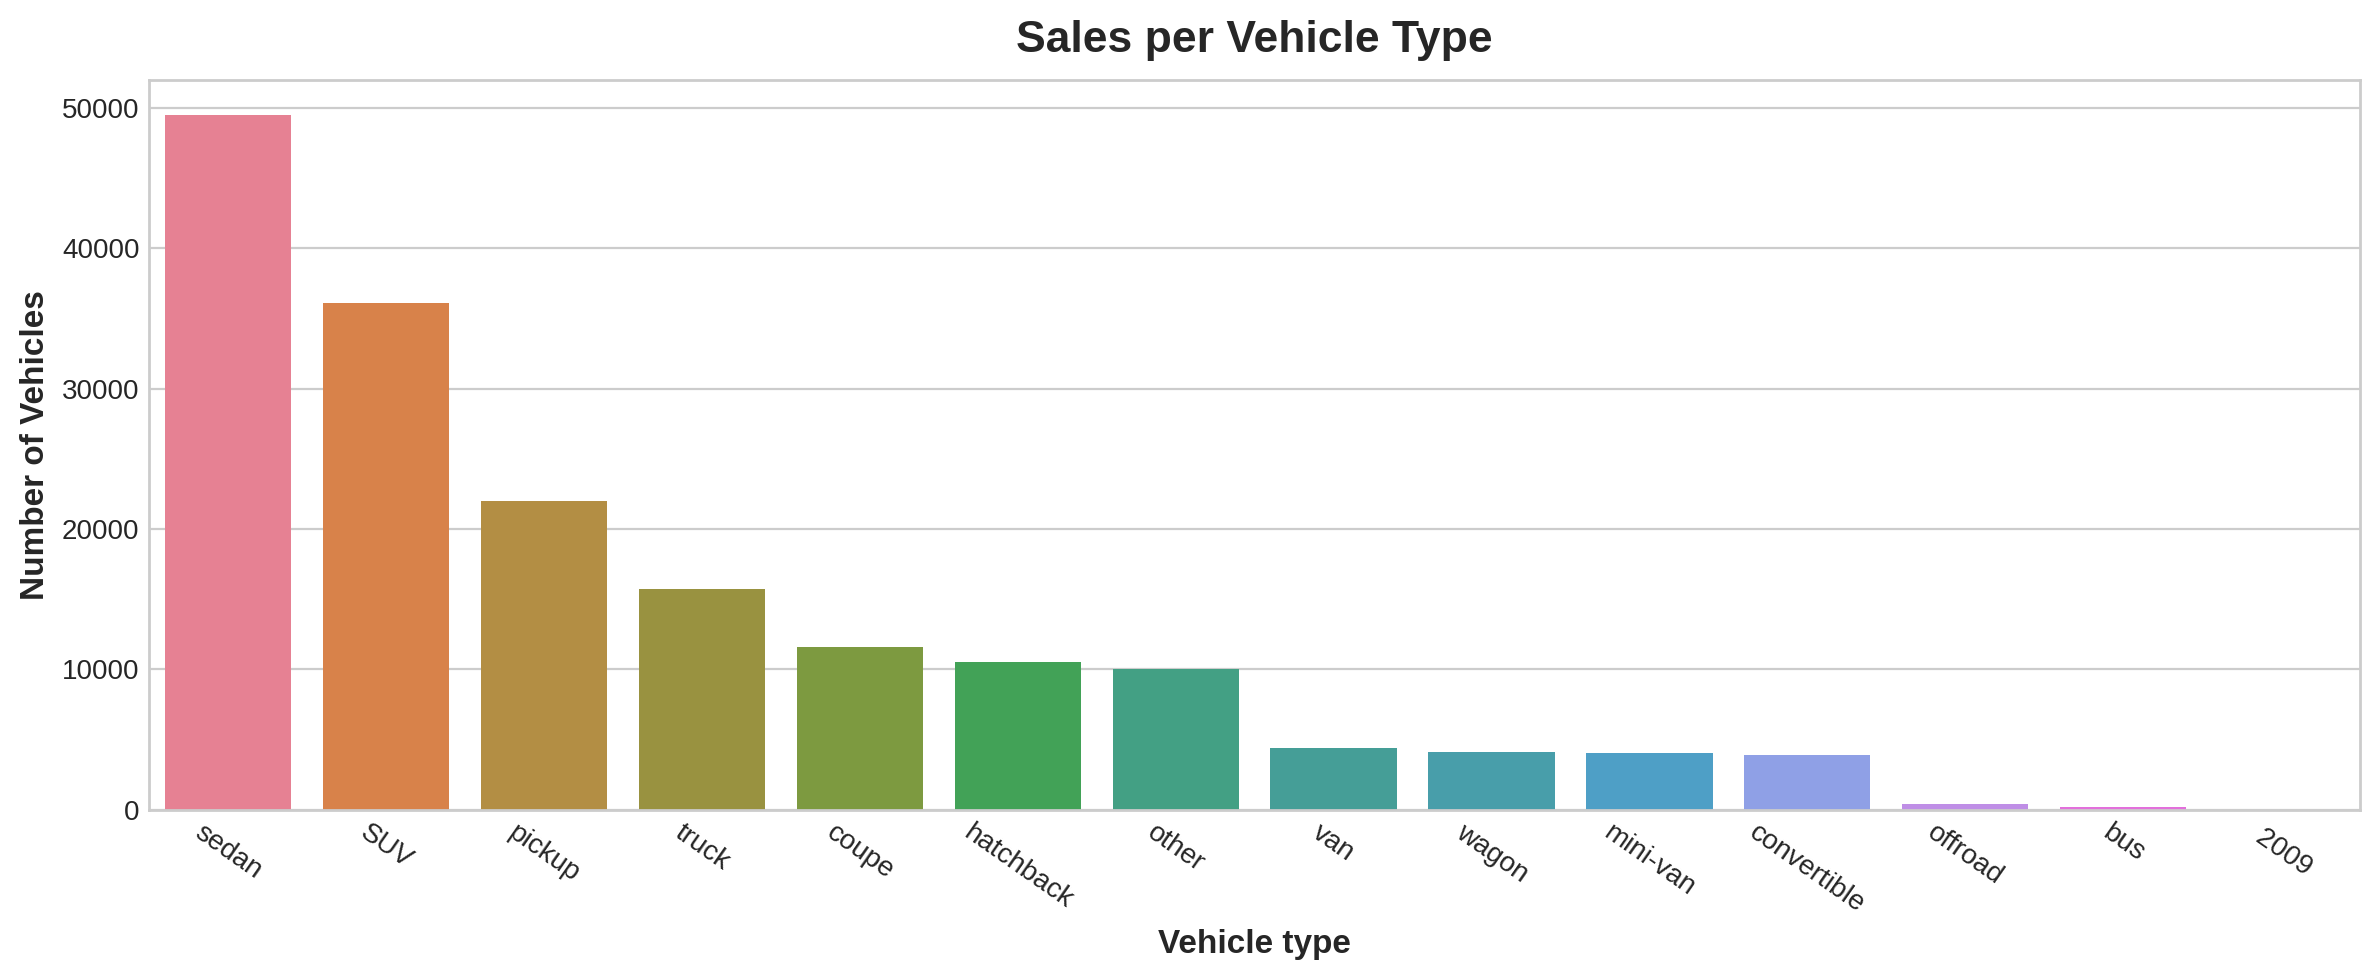

In [13]:
# Vehicle type sales

# group by type and posting_year
vehicle_type = vehicles_pandas.groupby("type")["posting_year"].count().reset_index(name="count")
# sort by count in descending order
vehicle_type = vehicle_type.sort_values(by="count", ascending=False)
# plot a bar plot
plt.figure(figsize=(12,5))
plt.xticks(rotation= -35)
sns.barplot(data= vehicle_type,x="type",y="count", hue="type")
plt.xlabel("Vehicle type")
plt.ylabel("Number of Vehicles")
plt.title("Sales per Vehicle Type")
plt.show()

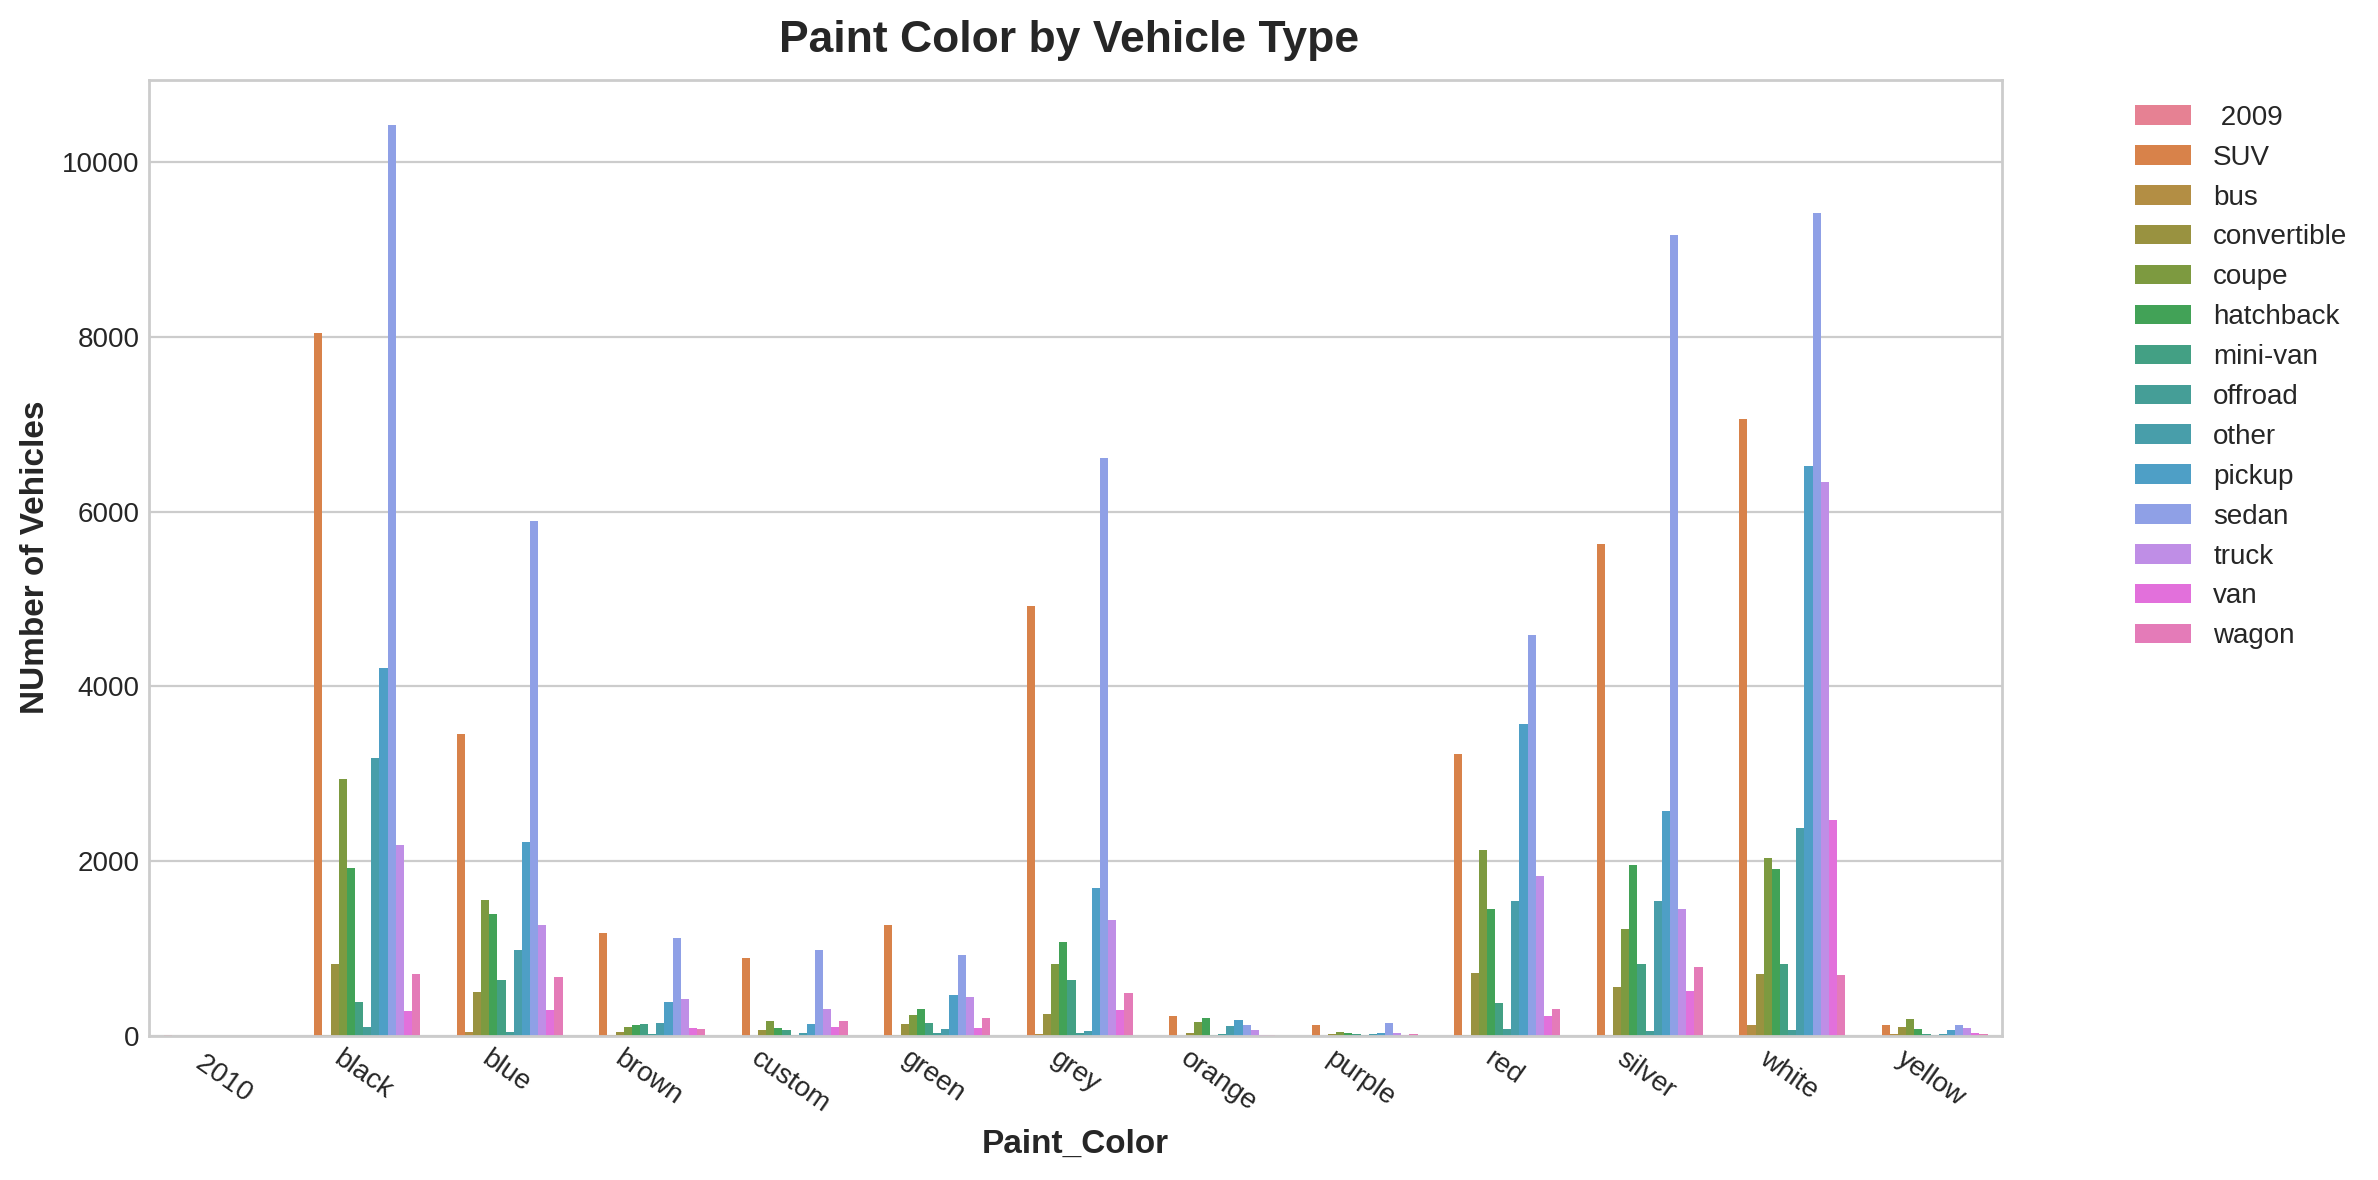

In [14]:
# Distribution of paint color for each vehicle type

# group by type and paint color
type_color = vehicles_pandas.groupby(["paint_color", "type"]).size().reset_index(name="count")
#plot the vehicle type-color distribution
plt.figure(figsize=(12, 6))
plt.xticks(rotation= -35)
sns.barplot(data=type_color, x="paint_color", y="count", hue="type")
plt.xlabel("Paint_Color")
plt.ylabel("NUmber of Vehicles")
plt.title("Paint Color by Vehicle Type ")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


Black,White and silver paint color are more dominant in comparison to other colors for Sedan and SUV vehicle types.

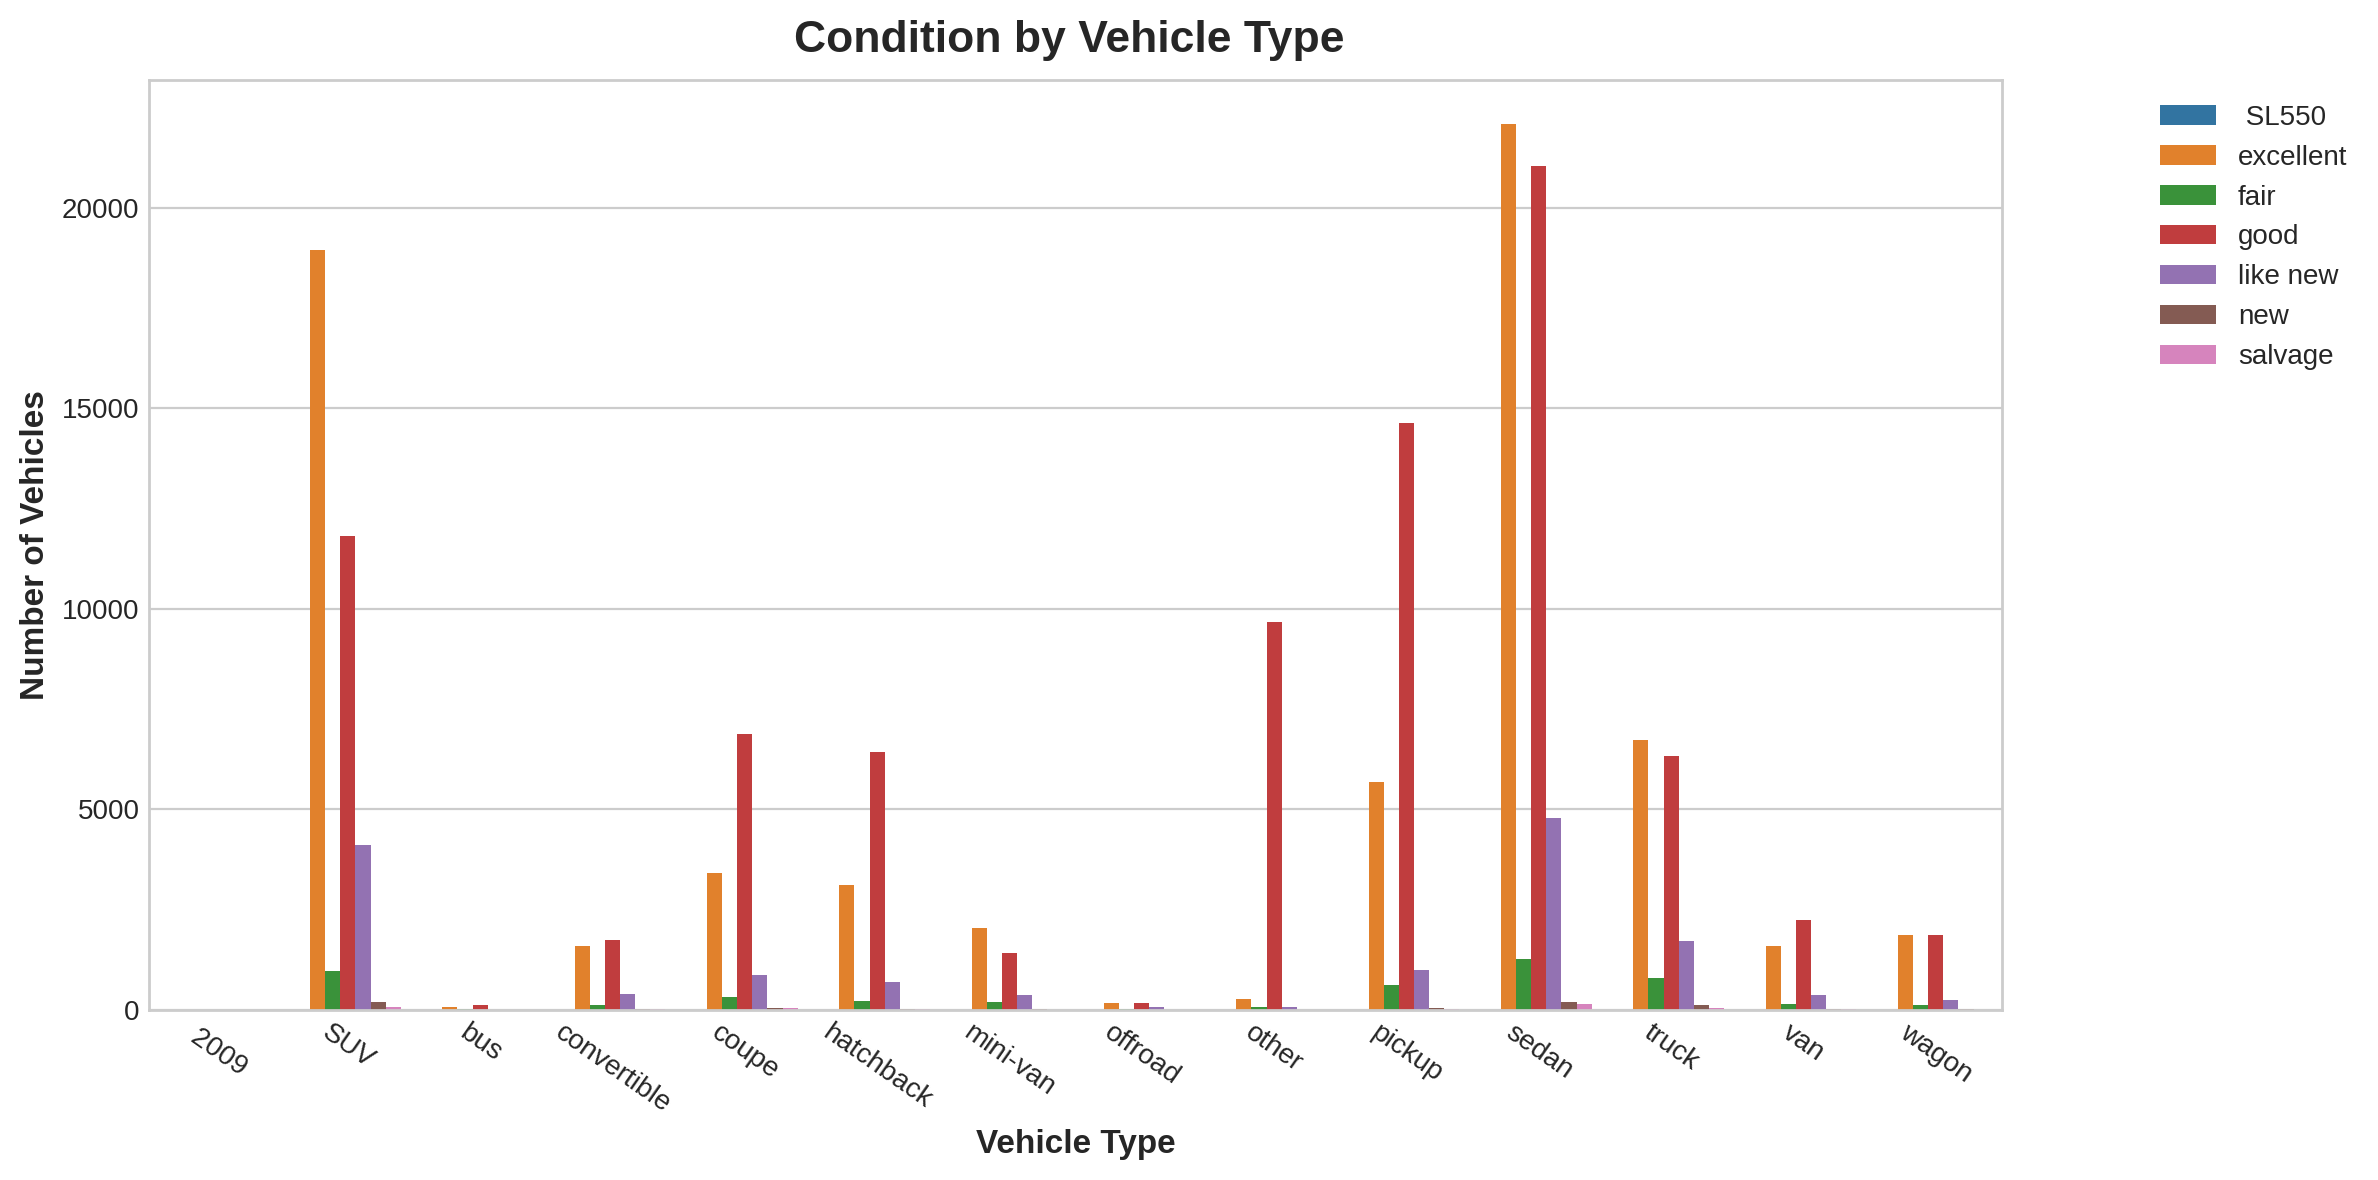

In [15]:
# Condition by vehicle type

# group by type and paint color
type_condition = vehicles_pandas.groupby(["condition", "type"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
plt.xticks(rotation= -35)
sns.barplot(data=type_condition, x="type", y="count", hue="condition")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Vehicles")
plt.title("Condition by Vehicle Type ")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Both Sedan and SUV have a big number of vehicles in good and excellent condition. They likewise have big numbers of vehicles in salvage condition. Buses and offroad have minimal to none vehicles in bad conditions.

23/10/25 11:26:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


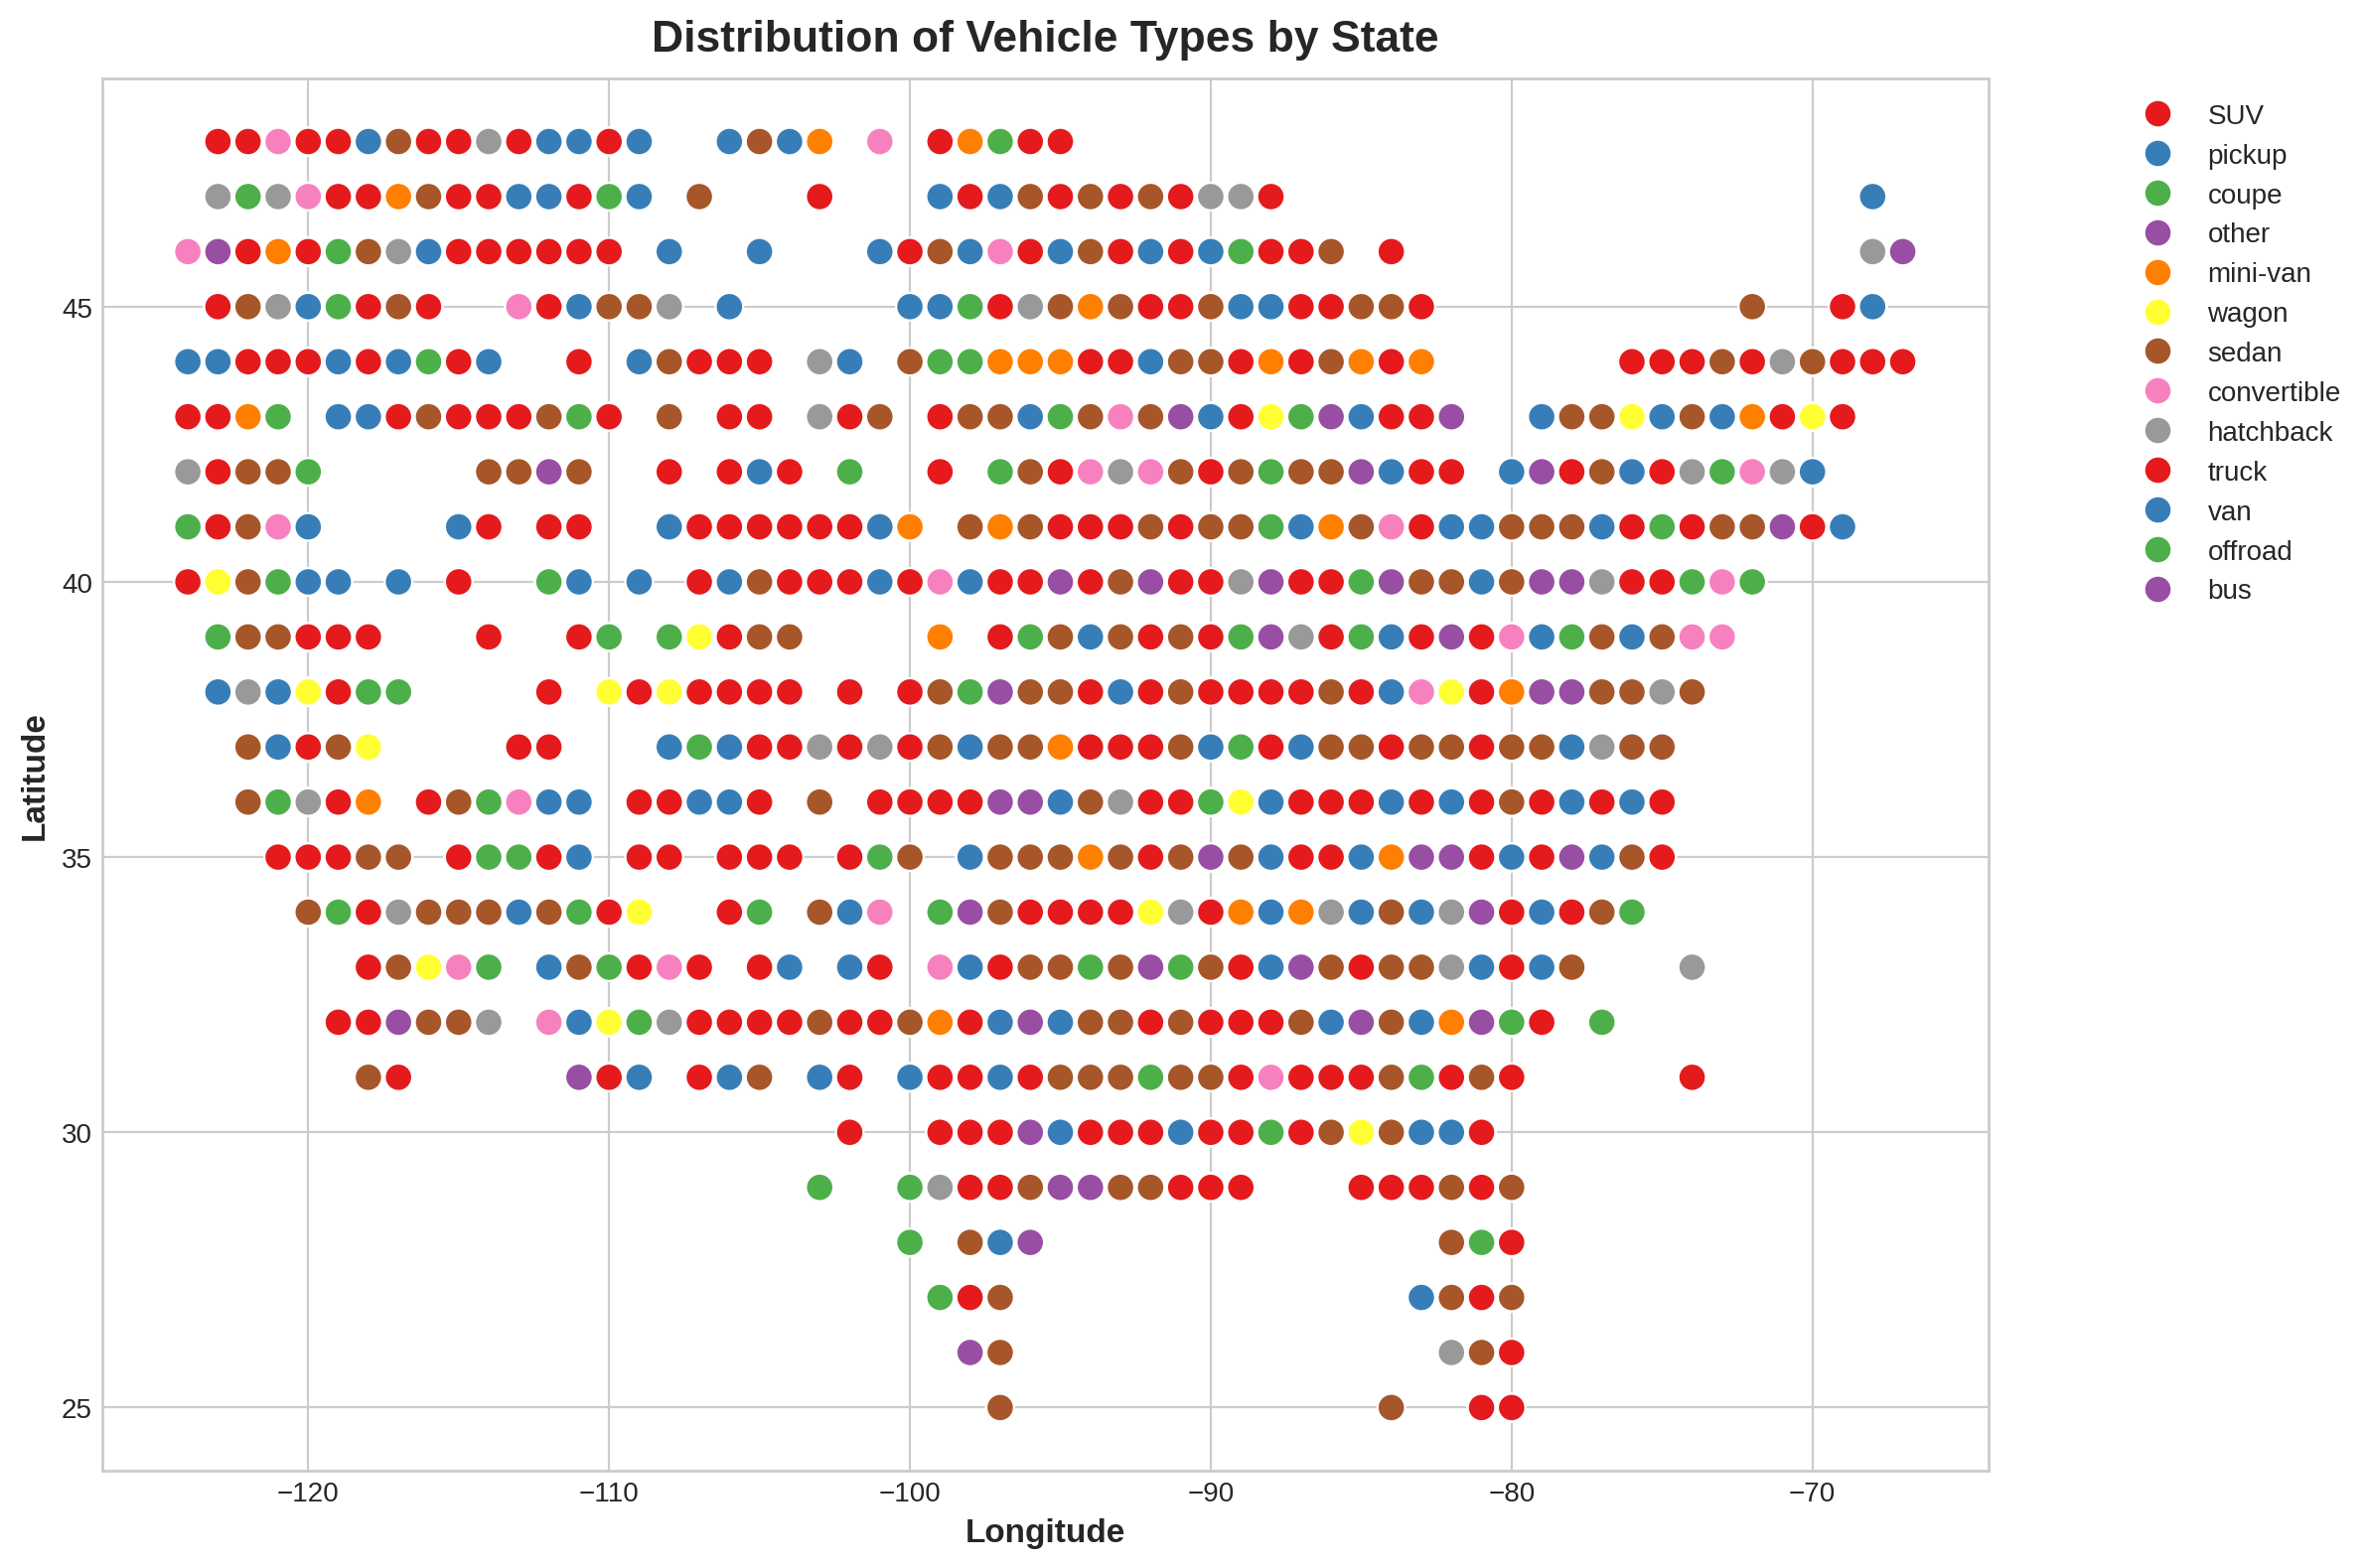

In [16]:
# Vehicle types by state

# Filter the data to remove outliers
type_states = vehicles_pandas[
    (vehicles_pandas['lat'] > 24) & (vehicles_pandas['lat'] < 50) &
    (vehicles_pandas['long'] > -125) & (vehicles_pandas['long'] < -65)
]
# Create the scatterplot
type_palette = sns.color_palette("Set1", len(type_states['type'].unique()))
plt.figure(figsize=(12, 8))
plt.title('Distribution of Vehicle Types by State')
scatterplot = sns.scatterplot(data=type_states,x="long",y="lat",hue='type',palette=type_palette,legend="full",s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Display the legend outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [18]:
# Save to CSV
vehicles_pandas.to_csv('Craiglist.csv')